# Assignment: Data Wrangling
### `! git clone https://github.com/ds4e/wrangling`
### Do Q1 and Q2, and either Q3 or Q4, for a total of 3 questions. 

**Q1.** This question provides some practice cleaning variables which have common problems.
1. Numeric variable: For `./data/airbnb_hw.csv`, clean the `Price` variable as well as you can, and explain the choices you make. How many missing values do you end up with? (Hint: What happens to the formatting when a price goes over 999 dollars, say from 675 to 1,112?)
   * I just basically rid, based on the Price column, of outliers beyond the .25 and .75 quantiles. I didn't really have missing values, but there were 1518 values that were beyond the lower and upper range I set. These 1518 rows were removed.
  
2. Categorical variable: For the Minnesota police use of for data, `./data/mn_police_use_of_force.csv`, clean the `subject_injury` variable, handling the NA's; this gives a value `Yes` when a person was injured by police, and `No` when no injury occurred. What proportion of the values are missing? Is this a concern? Cross-tabulate your cleaned `subject_injury` variable with the `force_type` variable. Are there any patterns regarding when the data are missing? 
   * According to the code below, out of the 12925 rows, 9848 rows were missing data, or had nan, in the subject_injury column. This is a huge concern because that is 3/4 of the data with no data in that column. If we just removed these 9848 rows, we would miss all the large amount of data possible in the other columns. However, if we were thinking about this semantically, it'd be nice to know if the subject was injured, but it might not be necessary to know if the police used force overall. It depends on what column you look at that you call this large amount of missing data as "concerning". 
   * I just changed the Nans to "Unknown" without removing the 9848 rows.
   * Based on the cross tab lambda function to show how many missing values there are per feature, it appears that there's a weak pattern. `Less lethal` and `Maximal Restraint Technique` both show 100% missing values while `Firearm` and `Less Lethal Projectile` both show 0% missing data. Maybe when projectiles are involved, there's a stricter standard to report these incidents while whatever the 100% missing value rate features might have no restrictions on reporting. Somehow, it appears that the `taser` reports high amounts of missing data on injuries. It might be that subjects of tasers aren't easily injured by the taser in this dataset, but I feel like getting tased might cause a few bruises or painful days. It's interesting to me that this could happen, and the same goes for `bodily force`.

3. Dummy variable: For the pretrial data covered in the lecture, clean the `WhetherDefendantWasReleasedPretrial` variable as well as you can, and, in particular, replace missing values with `np.nan`.
   * It appears there was a weird 9 value other than 0 and 1, and there was 31 9's out of the total thousands of values. I just changed all 9's to np.nan in the column since it appeared they were either outliers or disguised unknowns.

4. Missing values, not at random: For the pretrial data covered in the lecture, clean the `ImposedSentenceAllChargeInContactEvent` variable as well as you can, and explain the choices you make. (Hint: Look at the `SentenceTypeAllChargesAtConvictionInContactEvent` variable.)
   * I explain most of my choices in the cell 1.4 listed below, but I just replaced nans or unkonwn values like ' ' to np.nan, "eliminate" outliers by taking the lower and upper bounds then keeping inclusively what's between both. I also convert the data types to floats by coercion, though there's probably a better way to format the numbers back from original strings.
   * There's probably a better way to convert from strings to numeric types, but I coerced as I couldn't find a way.

In [5]:
import numpy as np # Import the numpy package into your workspace
import matplotlib.pyplot as plt # Import matplotlib into your workspace
import pandas as pd  # Import the pandas package into your workspace

In [214]:
#Q1.1: 
airbnb_df = pd.read_csv('./data/airbnb_hw.csv', low_memory=False)

#To look at the data's properties: row x col, and column names/types: looks like Price is object type :(
print(airbnb_df.shape, '\n')
print(airbnb_df.columns, '\n')
print(airbnb_df.dtypes, '\n')

# replace $ and , - special characters removed, then coerce to numeric
airbnb_df['Price'] = airbnb_df['Price'].str.replace('$', '', regex=False)
airbnb_df['Price'] = airbnb_df['Price'].str.replace(',', '', regex=False)
airbnb_df['Price'] = pd.to_numeric(airbnb_df['Price'], errors='coerce')

#More checks on data, if any values are na (looks like no) and the .25, .75 quantiles of data
print(airbnb_df.dtypes, '\n')
missing_count = airbnb_df['Price'].isna().sum()
print(missing_count)
price_summary = airbnb_df['Price'].describe(percentiles=[0.25, 0.75])
print(price_summary)

#Use quantiles and to calculate lower and upper bounds of "legit" vs outlier data
Q1 = airbnb_df['Price'].quantile(0.25)
Q3 = airbnb_df['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#Pre-check on how many outliers there are
outliers = airbnb_df[(airbnb_df['Price'] < lower_bound) | (airbnb_df['Price'] > upper_bound)]
print(len(outliers))

#Take out outliers & only keep those between upper/lower bounds
airbnb_df = airbnb_df[(airbnb_df['Price'] >= lower_bound) & (airbnb_df['Price'] <= upper_bound)]

#Post-check on how many outliers are left (should be 0)
outliers_cleaned = airbnb_df[(airbnb_df['Price'] < lower_bound) | (airbnb_df['Price'] > upper_bound)]
print(len(outliers_cleaned))

#I put na value imputation here after cleaning outliers - compute median of non-outlier data, then find new median to do imputation
median_price = airbnb_df['Price'].median()
airbnb_df['Price'] = airbnb_df['Price'].fillna(median_price)

(30478, 13) 

Index(['Host Id', 'Host Since', 'Name', 'Neighbourhood ', 'Property Type',
       'Review Scores Rating (bin)', 'Room Type', 'Zipcode', 'Beds',
       'Number of Records', 'Number Of Reviews', 'Price',
       'Review Scores Rating'],
      dtype='object') 

Host Id                         int64
Host Since                     object
Name                           object
Neighbourhood                  object
Property Type                  object
Review Scores Rating (bin)    float64
Room Type                      object
Zipcode                       float64
Beds                          float64
Number of Records               int64
Number Of Reviews               int64
Price                          object
Review Scores Rating          float64
dtype: object 

Host Id                         int64
Host Since                     object
Name                           object
Neighbourhood                  object
Property Type                  object
Review Scores Rating (bin)  

In [212]:
#Q1.2: 
police_df = pd.read_csv('./data/mn_police_use_of_force.csv',low_memory=False)

#These prints tell me that there's 12925 rows, but 9848 rows with nan for subject_injury
#That's a lot, so we're probably not gonna want to delete them
print(police_df.shape)
missing_injury = police_df['subject_injury'].isna().sum()
print(missing_injury)

missing_by_group = police_df.groupby('force_type')['subject_injury'].apply(lambda x: x.isna().mean())
print(missing_by_group)

#Cross-tabulating:
cross_tab_si_ft = pd.crosstab(police_df['subject_injury'], police_df['force_type'], normalize='columns')
print(cross_tab_si_ft)

police_df['subject_injury'] = police_df['subject_injury'].fillna('Unknown')

#Check that nans aren't there anymore:
missing_injury = police_df['subject_injury'].isna().sum()
print(missing_injury)

(12925, 13)
9848
force_type
Baton                         0.50
Bodily Force                  0.75
Chemical Irritant             0.89
Firearm                       0.00
Gun Point Display             0.26
Improvised Weapon             0.50
Less Lethal                   1.00
Less Lethal Projectile        0.00
Maximal Restraint Technique   1.00
Police K9 Bite                0.40
Taser                         0.75
Name: subject_injury, dtype: float64
force_type      Baton  Bodily Force  Chemical Irritant  Firearm  \
subject_injury                                                    
No               0.00          0.46               0.76     1.00   
Yes              1.00          0.54               0.24     0.00   

force_type      Gun Point Display  Improvised Weapon  Less Lethal Projectile  \
subject_injury                                                                 
No                           0.43               0.46                    0.33   
Yes                          0.57        

In [ ]:
#1.3:
url = 'http://www.vcsc.virginia.gov/pretrialdataproject/October%202017%20Cohort_Virginia%20Pretrial%20Data%20Project_Deidentified%20FINAL%20Update_10272021.csv'
pretrial_df = pd.read_csv(url,low_memory=False)

# This indicates that there are 0 "missing values" hmm
missing_releasedpretrial = pretrial_df['WhetherDefendantWasReleasedPretrial'].isna().sum()
print(missing_releasedpretrial)

# Im gonna check for disguised missing values
# It looks like there's a weird 9 value, and there's only 31 of them, so it's missing value representative (shown by the graph)
print(pretrial_df['WhetherDefendantWasReleasedPretrial'].unique())
print(pretrial_df['WhetherDefendantWasReleasedPretrial'].value_counts())

# Replace missing 9 values with np.nan:
pretrial_df['WhetherDefendantWasReleasedPretrial'] = pretrial_df['WhetherDefendantWasReleasedPretrial'].replace(9, np.nan)

# These check that there's now only 2 unique values, 0 and 1:
print(pretrial_df['WhetherDefendantWasReleasedPretrial'].unique())
print(pretrial_df['WhetherDefendantWasReleasedPretrial'].value_counts())


0
[9 0 1]
WhetherDefendantWasReleasedPretrial
1    19154
0     3801
9       31
Name: count, dtype: int64
[nan  0.  1.]
WhetherDefendantWasReleasedPretrial
1.00    19154
0.00     3801
Name: count, dtype: int64


In [ ]:
#1.4
# Uncomment if you need to reload data for some reason:
# url = 'http://www.vcsc.virginia.gov/pretrialdataproject/October%202017%20Cohort_Virginia%20Pretrial%20Data%20Project_Deidentified%20FINAL%20Update_10272021.csv'
# pretrial_df = pd.read_csv(url,low_memory=False)

# Check values of dataset:
print(pretrial_df['ImposedSentenceAllChargeInContactEvent'].info())
print(pretrial_df['ImposedSentenceAllChargeInContactEvent'].unique())

# There are strings, but more importantly, there are ' ' in this dataset. I'm gonna fix by replacing with np.nan:
pretrial_df['ImposedSentenceAllChargeInContactEvent'] = (
    pretrial_df['ImposedSentenceAllChargeInContactEvent']
    .str.strip()
    .replace('', np.nan)
)
print(pretrial_df['ImposedSentenceAllChargeInContactEvent'].unique())

# Now that the ' ' are gone, I'm going to coerce to numeric:
pretrial_df['ImposedSentenceAllChargeInContactEvent'] = pd.to_numeric(
    pretrial_df['ImposedSentenceAllChargeInContactEvent'], errors='coerce'
)
# print(pretrial_df['ImposedSentenceAllChargeInContactEvent'].unique())

# Gonna now find outliers:
print(pretrial_df['ImposedSentenceAllChargeInContactEvent'].describe())

Q1 = pretrial_df['ImposedSentenceAllChargeInContactEvent'].quantile(0.25)
Q3 = pretrial_df['ImposedSentenceAllChargeInContactEvent'].quantile(0.75)
IQR = Q3 - Q1

# Like in an earlier question, gonna find lower and upper bound to "eliminate" outliers - not winsorizing
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

pretrial_df = pretrial_df[
    (pretrial_df['ImposedSentenceAllChargeInContactEvent'] >= lower_bound) &
    (pretrial_df['ImposedSentenceAllChargeInContactEvent'] <= upper_bound)
]
# OPTION winsorizing. I chose not to because I didn't want the median to replace data points. I wanted to use np.nan, so I did so
# lower_bound = pretrial_df['ImposedSentenceAllChargeInContactEvent'].quantile(0.05)
# upper_bound = pretrial_df['ImposedSentenceAllChargeInContactEvent'].quantile(0.95)

# pretrial_df['ImposedSentenceAllChargeInContactEvent'] = pretrial_df['ImposedSentenceAllChargeInContactEvent'].clip(lower_bound, upper_bound)

# Now, we should have a set without "outliers", floats, and nans/other unknown values set to np.nan

<class 'pandas.core.series.Series'>
RangeIndex: 22986 entries, 0 to 22985
Series name: ImposedSentenceAllChargeInContactEvent
Non-Null Count  Dtype 
--------------  ----- 
22986 non-null  object
dtypes: object(1)
memory usage: 179.7+ KB
None
[' ' '60' '12' '.985626283367556' '36' '6' '24' '5.91375770020534' '120'
 '72' '11.9917864476386' '0' '2.95687885010267' '84' '108' '300' '240'
 '180' '4' '96' '2' '54' '.328542094455852' '44' '5' '115' '132' '48'
 '258' '34' '76' '.164271047227926' '.131416837782341' '111' '9' '3'
 '1.97125256673511' '36.9856262833676' '.0657084188911704'
 '35.4928131416838' '106.492813141684' '8' '35' '18.3141683778234' '480'
 '32' '93' '234' '732' '1.16427104722793' '4.6570841889117' '21' '7'
 '4.49281314168378' '18' '600' '43.1642710472279' '179' '52' '30' '20'
 '192' '702' '14' '55' '53' '11.9055441478439' '114' '35.0061601642711'
 '68' '.657084188911704' '46.6242299794661' '102' '65' '200' '57'
 '24.3285420944559' '12.1642710472279' '117' '81.4928131416838'
 

**Q2.** Go to https://sharkattackfile.net/ and download their dataset on shark attacks.

1. Open the shark attack file using Pandas. It is probably not a csv file, so `read_csv` won't work.
2. Drop any columns that do not contain data.
3. Clean the year variable. Describe the range of values you see. Filter the rows to focus on attacks since 1940. Are attacks increasing, decreasing, or remaining constant over time?
   * According to the graph, it appears the trend is increasing for attacks over time. However, this could just mean there's a lot more people going into shark zones and the shark attacks are therefore increasing due to more exposure to humans. I'm not sure. I don't know what would cause this trend.
   * graph below
4. Clean the Age variable and make a histogram of the ages of the victims.
   * histogram below
5. What proportion of victims are male?
   * 0.8454339194554736 or 0.85 around are male victims.
6. Clean the `Type` variable so it only takes three values: Provoked and Unprovoked and Unknown. What proportion of attacks are unprovoked?
   * 0.9104064039408867 or around 0.91 of the attacks were unprovoked.
7. Clean the `Fatal Y/N` variable so it only takes three values: Y, N, and Unknown.
8. Are sharks more likely to launch unprovoked attacks on men or women? Is the attack more or less likely to be fatal when the attack is provoked or unprovoked? Is it more or less likely to be fatal when the victim is male or female? How do you feel about sharks?
   * According to below, it appears more attacks are on men, more fatal when the attack is unprovoked, and more fatal for males than females. 
   * I am feeling great because males have a higher chance of dying when a shark is provoked but not so great because being attacked unprovoked is a lot worse than provoked. For the higher male proportions in fatality, it could be because men may have higher chances of challenging animals to fight. 

9.  What proportion of attacks appear to be by white sharks? (Hint: `str.split()` makes a vector of text values into a list of lists, split by spaces.)
    * 428 attacks appear to be by white sharks.

2
0
float64
True
False
True
False
Unique Years: [np.int64(1940), np.int64(1941), np.int64(1942), np.int64(1943), np.int64(1944), np.int64(1945), np.int64(1946), np.int64(1947), np.int64(1948), np.int64(1949), np.int64(1950), np.int64(1951), np.int64(1952), np.int64(1953), np.int64(1954), np.int64(1955), np.int64(1956), np.int64(1957), np.int64(1958), np.int64(1959), np.int64(1960), np.int64(1961), np.int64(1962), np.int64(1963), np.int64(1964), np.int64(1965), np.int64(1966), np.int64(1967), np.int64(1968), np.int64(1969), np.int64(1970), np.int64(1971), np.int64(1972), np.int64(1973), np.int64(1974), np.int64(1975), np.int64(1976), np.int64(1977), np.int64(1978), np.int64(1979), np.int64(1980), np.int64(1981), np.int64(1982), np.int64(1983), np.int64(1984), np.int64(1985), np.int64(1986), np.int64(1987), np.int64(1988), np.int64(1989), np.int64(1990), np.int64(1991), np.int64(1992), np.int64(1993), np.int64(1994), np.int64(1995), np.int64(1996), np.int64(1997), np.int64(1998), np.int6

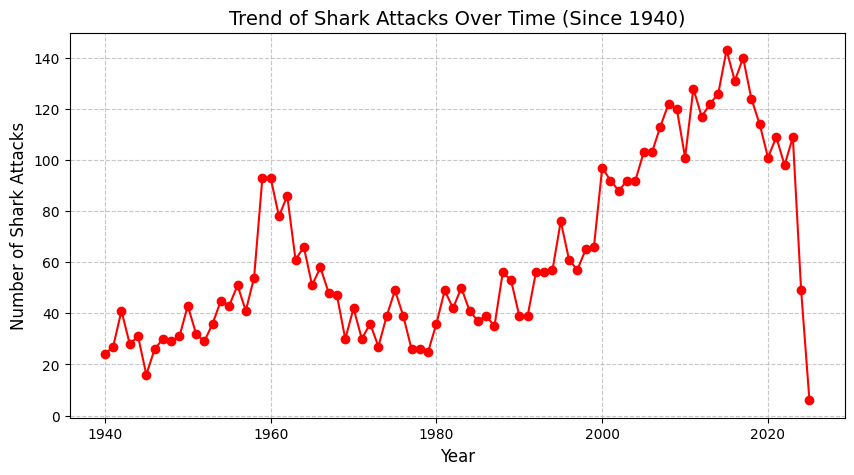

(5457, 23)
1778
0
object
float64
121
0
int64
False
False
The proportion of males in this dataset is:  0.8454339194554736
Type
Unprovoked             2957
Provoked                291
Invalid                 205
Watercraft               41
Sea Disaster             38
Questionable             15
?                         1
Under investigation       1
Name: count, dtype: int64
Type
Unprovoked    2957
Provoked       291
Name: count, dtype: int64
Proportion of attacks unprovoked:  0.9104064039408867
Fatal Y/N
N          2737
Y           490
UNKNOWN      12
Name: count, dtype: int64
Sex
M    2724
F     496
Name: count, dtype: int64
0.9027165932452276 0.9576612903225806 It appears it's more common for sharks to attack males unprovoked than females
0.16305818673883626 0.027491408934707903 It appears it's more fatal when sharks attack unprovoked than provoked
0.15198237885462554 0.14112903225806453 It appears it's more fatal when sharks attack provoked given male rather than female
According to 

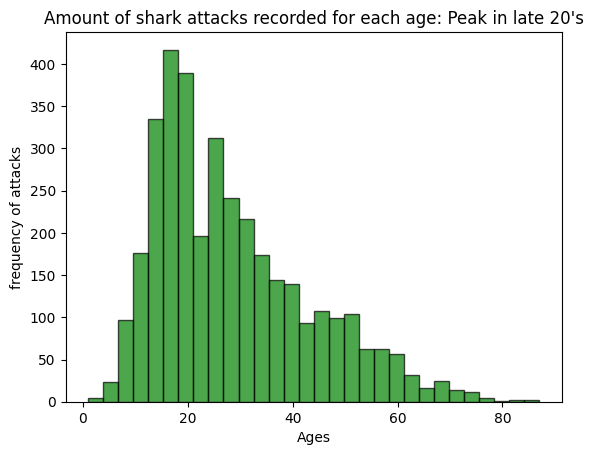

In [211]:
#2.1
# uncomment line if you need xlrd or error comes up (might need to do this in terminal if doesn't work after)
# ! pip install xlrd
file = "./data/GSAF5.xls"
shark_df = pd.read_excel(file, engine="xlrd")

#2.2
# Checking which columns are completely empty & removing them:
# empty_cols = shark_df.columns[shark_df.isna().all()]
# print(empty_cols)
shark_df = shark_df.dropna(axis=1, how="all") # I printed out that no columns were completely empty, but I just removed them with this

#2.3
# print(shark_df.describe)
years_missing = shark_df['Year'].isna().sum()
print(years_missing)
# apparently there's 2 missing values. Let's remove:
shark_df = shark_df.dropna(subset=['Year'])
years_missing = shark_df['Year'].isna().sum()
print(years_missing)
print(shark_df['Year'].dtypes) # proves values are floats or number
shark_df['Year'] = shark_df['Year'].astype(int)
print(shark_df['Year'].max() > 2025) # why are there years greater than 2025. :(
shark_df = shark_df[shark_df['Year'] <= 2025]
print(shark_df['Year'].max() > 2025) #yey
print(shark_df['Year'].min() < 1940) #nooo
shark_df = shark_df[shark_df['Year'] >= 1940]
print(shark_df['Year'].min() < 1940) #yey
print("Unique Years:", sorted(shark_df['Year'].unique()))
# Visualizing the trend of attacks per year 1940-2025:
attack_trend = shark_df['Year'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.plot(attack_trend.index, attack_trend.values, marker='o', linestyle='-', color='red')
plt.title("Trend of Shark Attacks Over Time (Since 1940)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Shark Attacks", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

#2.4
# print(shark_df.describe)
print(shark_df.shape)
age_missing = shark_df['Age'].isna().sum()
print(age_missing)
# apparently there's 2994 missing values. Let's remove:
shark_df = shark_df.dropna(subset=['Age'])
age_missing = shark_df['Age'].isna().sum()
print(age_missing)
print(shark_df['Age'].dtypes) # proves values are Object-> need to change
shark_df['Age'] = pd.to_numeric(shark_df['Age'], errors='coerce')
print(shark_df['Age'].dtypes) #yay - float
age_missing = shark_df['Age'].isna().sum()
print(age_missing) #WHYY there's missing values again
shark_df = shark_df.dropna(subset=['Age'])
age_missing = shark_df['Age'].isna().sum()
print(age_missing) #yey
shark_df['Age'] = shark_df['Age'].astype(int)
print(shark_df['Age'].dtypes) #converted to int bc ages are int usually- after nans are gone
print(shark_df['Age'].min() < 1) #good it's false
print(shark_df['Age'].min() > 100) #okay that's false too
plt.hist(shark_df['Age'], bins=30, color='green', edgecolor='black', alpha=0.7)
plt.xlabel("Ages")
plt.ylabel("frequency of attacks")
plt.title("Amount of shark attacks recorded for each age: Peak in late 20's")

#2.5
shark_df['Sex'] = shark_df['Sex'].str.strip().str.upper()
number_male = (shark_df['Sex'] == 'M').sum()
amount_in_shark = shark_df['Sex'].notna().sum()
proportion_male = number_male / amount_in_shark
print("The proportion of males in this dataset is: ", proportion_male)

#2.6
print(shark_df['Type'].value_counts())
shark_df = shark_df[shark_df['Type'].isin(["Provoked", "Unprovoked", "Unknown"])]
print(shark_df['Type'].value_counts())
provok_number = (shark_df['Type'] == 'Unprovoked').sum()
# print(provok_number)
amount_in_shark_provok = shark_df['Type'].notna().sum()
print("Proportion of attacks unprovoked: ", provok_number/amount_in_shark_provok)

#2.7
# print(shark_df['Fatal Y/N'].value_counts()) # wow so many close values
shark_df['Fatal Y/N'] = shark_df['Fatal Y/N'].str.strip().str.upper()
# print(shark_df['Fatal Y/N'].value_counts())
# print(shark_df.loc[shark_df['Fatal Y/N'].isin(["NQ", "Y X 2"])])
shark_df['Fatal Y/N'] = shark_df['Fatal Y/N'].replace({'Y X 2': 'Y'})
shark_df['Fatal Y/N'] = shark_df['Fatal Y/N'].replace({'NQ': 'UNKNOWN'})
shark_df['Fatal Y/N'] = shark_df['Fatal Y/N'].replace({'F': 'UNKNOWN', 'M': 'UNKNOWN'})
print(shark_df['Fatal Y/N'].value_counts())

#2.8
# For p(unprovoked | male) & p(unprovoked | female): (unprovoked & sex) / sex
shark_df = shark_df[~shark_df['Sex'].isin(["LLI"])]
print(shark_df['Sex'].value_counts())
number_unprovoked_male = shark_df[(shark_df['Type'] == 'Unprovoked') & (shark_df['Sex'] == 'M')].shape[0] / shark_df[shark_df['Sex'] == 'M'].shape[0]
number_unprovoked_female = shark_df[(shark_df['Type'] == 'Unprovoked') & (shark_df['Sex'] == 'F')].shape[0] / shark_df[shark_df['Sex'] == 'F'].shape[0]
print(number_unprovoked_male, number_unprovoked_female, "It appears it's more common for sharks to attack males unprovoked than females")
# For p(fatal | unprovoked) & p(fatal | provoked): (fatal & provoked) / provoked
number_fatal_unprovoked = shark_df[(shark_df['Fatal Y/N'] == 'Y') & (shark_df['Type'] == 'Unprovoked')].shape[0] / shark_df[shark_df['Type'] == 'Unprovoked'].shape[0]
number_fatal_provoked = shark_df[(shark_df['Fatal Y/N'] == 'Y') & (shark_df['Type'] == 'Provoked')].shape[0] / shark_df[shark_df['Type'] == 'Provoked'].shape[0]
print(number_fatal_unprovoked, number_fatal_provoked, "It appears it's more fatal when sharks attack unprovoked than provoked")
# For p(fatal | male) & p(fatal | female): (fatal & sex) / sex
number_fatal_male = shark_df[(shark_df['Fatal Y/N'] == 'Y') & (shark_df['Sex'] == 'M')].shape[0] / shark_df[shark_df['Sex'] == 'M'].shape[0]
number_fatal_female = shark_df[(shark_df['Fatal Y/N'] == 'Y') & (shark_df['Sex'] == 'F')].shape[0] / shark_df[shark_df['Sex'] == 'F'].shape[0]
print(number_fatal_male, number_fatal_female, "It appears it's more fatal when sharks attack provoked given male rather than female")
# I am feeling great because males have a higher chance of dying when a shark is provoked but not so great because being attacked unprovoked is a lot worse than provoked
# For the higher male proportions in fatality, it could be because men may have higher chances of challenging animals to fight. "Cockiness" maybe

#2.9
# print(shark_df['Species '].value_counts())
shark_df['Species '] = shark_df['Species '].str.strip().str.lower()
white_shark_attacks = shark_df['Species '].str.contains(r'\bwhite\b|\bgreat white\b', na=False).sum()
print("According to math, there are ", white_shark_attacks, " White sharks that attacked in this data set.")

**Q3.** Open the "tidy_data.pdf" document in the repo, which is a paper called Tidy Data by Hadley Wickham.

  1. Read the abstract. What is this paper about?
   * Based on the abstract, this paper is about a framework with limited tools to "tidy" up datasets, even the messy kinds.

  2. Read the introduction. What is the "tidy data standard" intended to accomplish?
   * The "Tidy Data standard" was, "designed to facilitate initial exploration and analysis of the data, and to simplify the development of data analysis tools that work well together." This means that the standard is meant to make the analysis process more efficient to encourage more exploration.

  3. Read the intro to section 2. What does this sentence mean: "Like families, tidy datasets are all alike but every messy dataset is messy in its own way." What does this sentence mean: "For a given dataset, it’s usually easy to figure out what are observations and what are variables, but it is surprisingly difficult to precisely define variables and observations in general."
   * In my interpretation, it seems we (humans) are able to define what are variables and observations from looking at a dataset or specific scenario. However, it's difficult to broadly and generally define what variables and observations to apply to new datasets or studies. For example, we can usually tell color or size might be column names in tables, or variables, but it can be interpreted differently in different data formats than a table.

  4. Read Section 2.2. How does Wickham define values, variables, and observations?
   * Wickham defines values as collected in datasets, usually numeric or in strings for quantitative or qualitative respectively. They belong to a variable and observation. He defines variables as containing all measurements for the same attribute or feature across units. He defines observations as values of a same unit across attributes or features.

  5. How is "Tidy Data" defined in section 2.3?
   * This is defined as having each variable forming a column, each observation forming a row, and each observation unit forming a table.

  6. Read the intro to Section 3 and Section 3.1. What are the 5 most common problems with messy datasets? Why are the data in Table 4 messy? What is "melting" a dataset?
   * the 5 most common problems are column headers are values not variable names, there being multiple variables stored in one column, variables being stored in both rows and columns, multiple types of observation units being stored in the same table, and a single observational unit being stored in multiple tables (according to the 5 bullet points). 
   * The data in table 4 are messy because the column headers are values (money amounts not names). Melting a dataset is to stack a dataset, or turn columns into rows. It's thought of also making "wide datasets" long or tall.
 
  7. Why, specifically, is table 11 messy but table 12 tidy and "molten"?
   * The table is large, and it actually looks like the column headers are values not variable names like d1 for a first date of month. The table 12 is able to keep the column numbers as low as possible, while giving at least one value per cell, such that it's easier to read. We "stacked" data by putting them in 2 tables to reference between each other, almost as if the tables are in first normal form.

  8. Read Section 6. What is the "chicken-and-egg" problem with focusing on tidy data? What does Wickham hope happens in the future with further work on the subject of data wrangling?
   * The chicken-and-egg problem is that, "if tidy data is only as useful as the tools that work with it, then tidy tools will be inextricably linked to tidy data." He means that we'd get stuck in a loop where new structures or tools for data will not make work more efficient in the future as we are stuck.
   * Wickham hopes "tidy data framework" isn't one of the "false starts" like this problem. However, he doesn't know the solution and hopes others will build on the framework and develop better data storage strategies with better tools. This actually feels like it's happened with no-sql databases since we're not dependent on table strict structure.

**Q4.** Many important datasets contain a race variable, typically limited to a handful of values often including Black, White, Asian, Latino, and Indigenous. This question looks at data gathering efforts on this variable by the U.S. Federal government.

1. How did the most recent US Census gather data on race?
   * According to the website in the next bullet point, the, "data are based on self-identification. People may choose to report more than one race group. People of any race may be of any ethnic origin." So, through self-identification was how the Census gathered data.
   * https://www.census.gov/topics/population/race.html 

2. Why do we gather these data? What role do these kinds of data play in politics and society? Why does data quality matter?
   *  Gathering this data provides insight into the different sub-populations of the US. If we know more about certain "races" or ethnicity, we might be able to make informed decisions in policy creation. For example, if the data shows that many people in one race have faced poverty more than in other races, we might know to push for policy that alleviates this issue for the equity of the US population. We might also know to search for the issue's cause so that we can help this group find better outcomes.
   *  The data quality matters so that we get the most accurate picture of the US populations. We can't have too much of an overfit or underfit if modeling the data, or else we can't generalize noticed patterns in future census outcomes.
  
3. Please provide a constructive criticism of how the Census was conducted: What was done well? What do you think was missing? How should future large scale surveys be adjusted to best reflect the diversity of the population? Could some of the Census' good practices be adopted more widely to gather richer and more useful data?
   * I think the self-identification process went well because people can now choose multiple options if they're multiracial. It allows the people to more so identify themselves rather than fit their identity into one box. 
   * However, it might be difficult to know which boxes to select if one doesn't know their ancestry (adopted people?). There might also be confusion on how each race identifies themselves per the Census guidelines. One person might say one race is from so and so, while another disagrees. With that, there are some groups missing like Middle Eastern and Northern Africa, which might cause further confusion among people who originate from this area.
   * To solve the issues, the government could require people to attend info sessions on how each race or ethnicity is defined per Census guidelines. 
   * The Census also has options in accessibility of language- they offer multiple languages and survey formats. We could probably adopt this sort of practice in other legal processes, such as in courtrooms (judges who speak multiple languages) or election ballots. This may increase quality of data in those processes since more people are able to participate.

4. How did the Census gather data on sex and gender? Please provide a similar constructive criticism of their practices.
   * So apparently, they, "ask a question about the sex of each person to create statistics about males and females and to present other data, such as occupation, by sex." They don't give any other option than male or female. This is according to the last bullet point in this problem.
   * This is kind of problematic because there are people out there who might not fully identify with just male or female. For example, there are people who might be confused because they have genetic conditions that make it so they appear female on the outside (physically) but have "male parts". They were born this way, yet there's no clear answer of male or female. 
   * The Census could include an "I don't know" type option for some of these options. This might actually provide more medical data or show how much of the population have similar conditions to inform further practices.
   * https://www.census.gov/acs/www/about/why-we-ask-each-question/sex/

5. When it comes to cleaning data, what concerns do you have about protected characteristics like sex, gender, sexual identity, or race? What challenges can you imagine arising when there are missing values? What good or bad practices might people adopt, and why?
   * When cleaning data, I'm concerned that there might be values that aren't presented in the standard pre-set options, such as " F" under female "F". We have to be careful not to "erase" these types of values because they still mean something, even if formatted incorrectly. 
   * When there are missing values, we still might care for the other column values for that observation. This data is highly important and every observation counts for informed policies on these datasets. Because of that, we need to still keep these values so that we can have a more "accurate" insight.
   * We can clearly document how we dealt with missing values since they're very important when people use data to make informed policies. We can also provide the option to self-describe or prefer not to say so that people don't have to put down a "random" value.
   * We don't want to fill missing values with one of the main options because this changes identity and the nuance of the person. We also don't want to flat out erase the rows that contain missing data because we'd be missing out on the other column values present for other info on the data.

6. Suppose someone invented an algorithm to impute values for protected characteristics like race, gender, sex, or sexuality. What kinds of concerns would you have?
   * I'm kind of concerned that we'd lose accuracy of results because we relied on a machine to calculate data on humans who have identities not based on machine logic. Humans are creatures with varying features, and to just impute a value based on a set logic doesn't seem right.
   * I'm also concerned that the algorithm will use other values such as location to classify people. So basically, it would stereotype (say race) based on locations, which doesn't work in reality. We'd be enforcing stereotypes into the dataset through the algorithm possibly.